# Data Exploration

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import mutual_info_regression

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [3]:
df = pd.read_csv('../input/2024-01-05/austin10_dataset.csv')
df.set_index(['dataid', 'timestamp'], inplace=True)
df.describe()

,air1,air2,airwindowunit1,bathroom1,bathroom2,bedroom1,bedroom2,bedroom3,car1,clotheswasher1,...,n_rooms,total_area,outdoor_temp,app_outdoor_temp,humidity,day,wday,month,year,hour
count,71807.000000,8695.000000,8993.000000,26461.000000,8671.000000,44911.000000,17680.000000,8695.000000,36019.000000,80369.000000,...,89949.000000,89949.000000,89929.000000,89929.000000,89929.000000,89949.000000,89949.000000,89949.000000,89949.000000,89949.00000
mean,0.461915,0.067874,0.040693,0.010521,0.001828,0.050609,0.083714,0.062924,0.228824,0.012018,...,8.813995,193.475307,20.538743,21.090641,0.696677,16.028405,2.990005,6.597683,2018.000600,11.49428
std,0.748997,0.204774,0.088988,0.014488,0.004828,0.062669,0.079472,0.067008,0.850636,0.034891,...,1.819717,33.908112,9.233662,10.393496,0.211698,8.802693,2.000456,3.388750,0.024495,6.92166
min,-0.012750,-0.018250,0.000000,-0.001000,-0.001000,-0.001000,0.000000,0.004000,-0.008750,-0.002750,...,5.000000,154.590000,-8.660000,-13.580000,0.130000,1.000000,0.000000,1.000000,2018.000000,0.00000
25%,0.000000,-0.005250,0.002250,0.002000,0.000000,0.008000,0.006250,0.007000,0.001000,0.000000,...,8.000000,159.790000,13.840000,13.840000,0.530000,8.000000,1.000000,4.000000,2018.000000,5.00000
50%,0.003750,-0.004500,0.023000,0.004250,0.000000,0.029000,0.059500,0.056000,0.002000,0.001000,...,10.000000,185.810000,22.260000,22.720000,0.740000,16.000000,3.000000,7.000000,2018.000000,11.00000
75%,0.716000,-0.003250,0.024000,0.024000,0.001500,0.068750,0.147250,0.076250,0.003000,0.002000,...,10.000000,213.680000,27.090000,28.890000,0.880000,24.000000,5.000000,9.000000,2018.000000,17.00000
max,4.146500,1.310250,1.303750,0.843250,0.065500,0.604750,0.520250,0.444250,7.328500,1.122000,...,11.000000,260.130000,41.990000,42.340000,1.000000,31.000000,6.000000,12.000000,2019.000000,23.00000


## Missing values
https://www.kaggle.com/code/alexisbcook/missing-values

In [4]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100

# Maximale Länge der Spaltennamen
max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

air1                	20.17%
air2                	90.33%
airwindowunit1      	90.00%
bathroom1           	70.58%
bathroom2           	90.36%
bedroom1            	50.07%
bedroom2            	80.34%
bedroom3            	90.33%
car1                	59.96%
clotheswasher1      	10.65%
diningroom1         	89.94%
dishwasher1         	0.55%
disposal1           	40.28%
drye1               	20.10%
dryg1               	70.34%
furnace1            	0.56%
furnace2            	90.33%
garage1             	89.93%
kitchen1            	80.28%
kitchen2            	90.33%
kitchenapp1         	30.38%
kitchenapp2         	60.59%
lights_plugs1       	30.01%
lights_plugs2       	30.02%
lights_plugs3       	50.14%
lights_plugs4       	90.01%
livingroom1         	60.67%
microwave1          	20.30%
office1             	59.77%
outsidelights_plugs1	90.36%
oven1               	50.23%
range1              	79.89%
refrigerator1       	20.31%
refrigerator2       	90.00%
utilityroom1        	80.74%
venthood1           	8

### Was auffällt: Da es z.B. mehrere Badezimmer gibt, ist es problematisch, dass nur wenige Häuse ein 2. Badezimmer besitzen und die meisten Einträge deshalb leer sind. Um dies zu umgehen, werden die Werte im Folgenden jeweils summiert

### Außerdem: Um Data Leakage zu verhindern, können beim Test-Schritt später offentsichtlich keine einzelnen Messwerte übergeben werden, um dennoch einen Teil der Informationen hiervon zu verwenden, wird die Anzahl der im Haus vorhandenen Geräte jeweils gespeichert

In [5]:
# Identifizieren der Spaltenpaare
spaltenpaare = {}
for spalte in df.columns:
    if spalte[-1].isdigit():
        basisname = spalte[:-1]
        if basisname in spaltenpaare:
            spaltenpaare[basisname].append(spalte)
        else:
            spaltenpaare[basisname] = [spalte]

# Schritt 2 und 3: Zusammenfassen der Spalten und Erstellen neuer Spalten
for basisname, spalten in spaltenpaare.items():
    df[basisname] = df[spalten].sum(axis=1, min_count=1)  # Summieren mit Berücksichtigung fehlender Werte
    df[f"n_{basisname}"] = df[spalten].notnull().sum(axis=1)  # Zählen der nicht-leeren Spalten

# Schritt 4: Entfernen der ursprünglichen Spalten
for spalten in spaltenpaare.values():
    df.drop(columns=spalten, inplace=True)

In [6]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100

# Maximale Länge der Spaltennamen
max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

outdoor_temp         	0.02%
app_outdoor_temp     	0.02%
humidity             	0.02%
air                  	20.17%
airwindowunit        	90.00%
bathroom             	60.94%
bedroom              	40.08%
car                  	59.96%
clotheswasher        	10.65%
diningroom           	89.94%
dishwasher           	0.55%
disposal             	40.28%
drye                 	20.10%
dryg                 	70.34%
furnace              	0.56%
garage               	89.93%
kitchen              	80.28%
kitchenapp           	30.38%
lights_plugs         	30.01%
livingroom           	60.67%
microwave            	20.30%
office               	59.77%
outsidelights_plugs  	90.36%
oven                 	50.23%
range                	79.89%
refrigerator         	20.31%
utilityroom          	80.74%
venthood             	80.34%


## Feature Importance
### Mutual Information
https://www.kaggle.com/code/ryanholbrook/mutual-information

Vorläufige Auffüllung durch Imputation, aber nicht auf den gespeicherten Datensatz, um Data Leakage zu verhindern

In [7]:
imputed_df = df.copy()

# Spalten für jede Imputationsstrategie bestimmen
few_missing = missing_share[(missing_share > 0) & (missing_share <= 5)].index.tolist()
moderate_missing = missing_share[(missing_share > 5) & (missing_share <= 50)].index.tolist()
many_missing = missing_share[missing_share > 50].index.tolist()

# Imputation
# 1. Wenig fehlende Daten: Ersetzen durch den Median
simple_imputer = SimpleImputer(strategy='median')
imputed_df[few_missing] = simple_imputer.fit_transform(imputed_df[few_missing])

# 2. Moderate fehlende Daten: KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_df[moderate_missing] = knn_imputer.fit_transform(imputed_df[moderate_missing])

# 4. Sehr viele fehlende Daten: Entfernung der Spalte
imputed_df.drop(many_missing, axis=1, inplace=True)

In [8]:
def create_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(10, 10))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

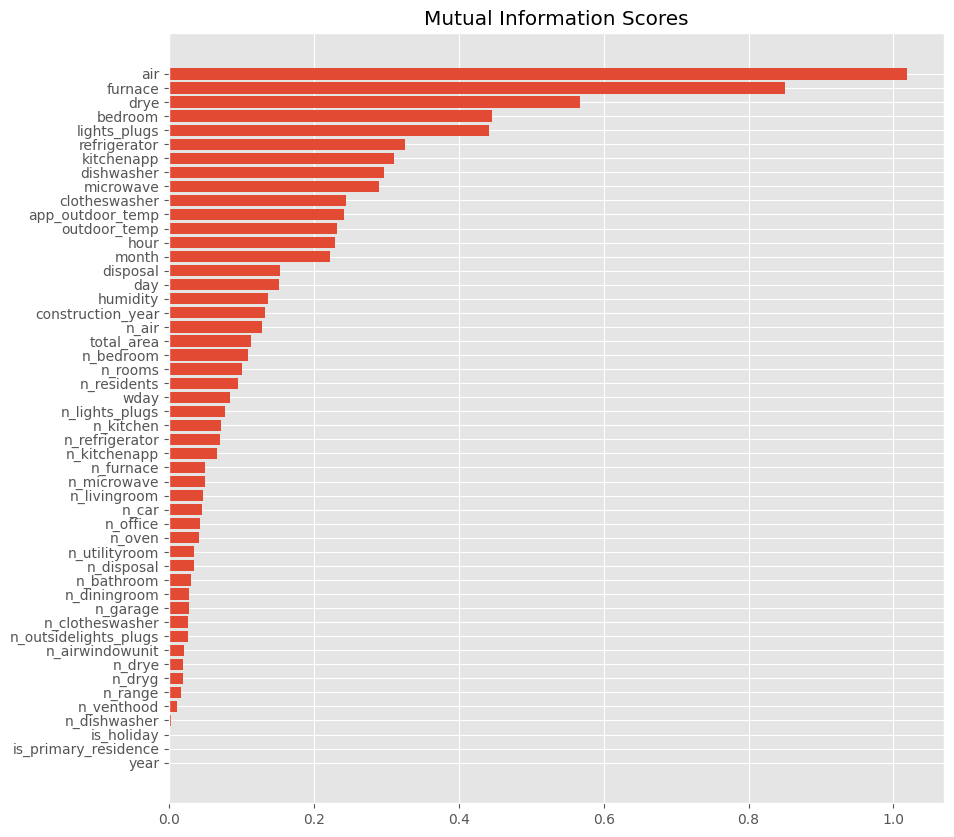

In [9]:
y = imputed_df.use
X = imputed_df.drop('use', axis=1)

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

mi_scores = create_mi_scores(X, y, discrete_features)
plot_mi_scores(mi_scores)

### 1. Warum hat is_holiday einen niedrigen MI Score?

<Axes: xlabel='is_holiday', ylabel='use'>

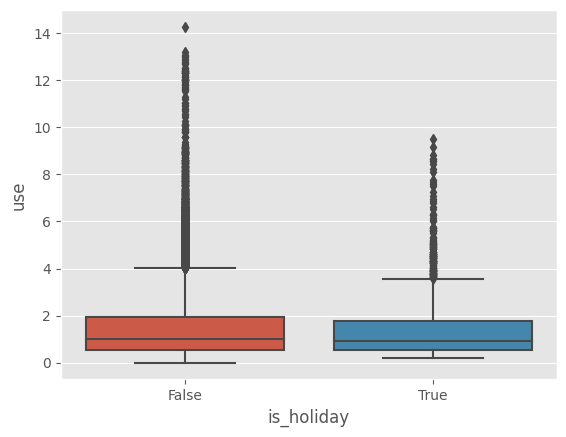

In [10]:
sns.boxplot(x="is_holiday", y="use", data=imputed_df)

#### Scheinbar hat ein Feiertag keinen bedeutenden Einfluss auf den Energieverbrauch

### 2. Warum haben "n_dishwasher", "year" und "is_primar_residence" einen niedrigen MI Score?

In [11]:
year_check = (imputed_df.year == 2018).mean() * 100
n_dishwasher_check = (imputed_df.n_dishwasher == 1).mean() * 100
is_primary_residence_check = imputed_df.is_primary_residence.mean() * 100

print(f"{year_check:.2f}% der Einträge stammen aus dem Jahr 2018.")
print(f"{n_dishwasher_check:.2f}% der Einträge enthalten genau einen Geschirrspüler.")
print(f"{is_primary_residence_check:.2f}% der Einträge sind als Hauptwohnsitz angegeben.")

99.94% der Einträge stammen aus dem Jahr 2018.
99.45% der Einträge enthalten genau einen Geschirrspüler.
100.00% der Einträge sind als Hauptwohnsitz angegeben.


#### Features sind nicht aussagekräftig, da (fast) alle Einträge gleich sind
### --> Enfernen dieser Features

In [12]:
less_important_features = ["is_holiday", "n_dishwasher", "year", "is_primary_residence"]
df.drop(less_important_features, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 89949 entries, (661, '2018-01-01 07:00:00') to (9922, '2019-01-01 05:00:00')
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   use                    89949 non-null  float64
 1   construction_year      89949 non-null  int64  
 2   n_residents            89949 non-null  int64  
 3   n_rooms                89949 non-null  int64  
 4   total_area             89949 non-null  float64
 5   outdoor_temp           89929 non-null  float64
 6   app_outdoor_temp       89929 non-null  float64
 7   humidity               89929 non-null  float64
 8   day                    89949 non-null  int64  
 9   wday                   89949 non-null  int64  
 10  month                  89949 non-null  int64  
 11  hour                   89949 non-null  int64  
 12  air                    71807 non-null  float64
 13  n_air                  89949 non-null  int64  
 14  air

In [13]:
# Als csv-Datei speichern
df.to_csv('austin10_hourly.csv')